In [315]:
import numpy as np
import jax.numpy as jnp
import pandas as pd
from glob import glob
from functools import partial
from types import SimpleNamespace
import functools
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from typing import Union

from lob_seq_model import LobPredModel

In [308]:
%load_ext autoreload
%autoreload 2

In [275]:
data_dir = '/nfs/home/peern/LOBS5/data/raw/'
save_dir = '/nfs/home/peern/LOBS5/data/'

In [276]:
message_files = sorted(glob(data_dir + '*message*.csv'))
book_files = sorted(glob(data_dir + '*orderbook*.csv'))

In [277]:
df = pd.read_csv(
    message_files[0],
    names=['time', 'event_type', 'order_id', 'size', 'price', 'direction'],
    index_col=False)

book = pd.read_csv(
    book_files[0],
    index_col=False,
    header=None
)

/nfs/home/peern/rlenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nfs/home/peern/rlenv/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


In [282]:
from bisect import bisect_left

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def relabel_series(s, allowed_labels=None):
    if allowed_labels is None:
        allowed_labels = sorted(s.unique())
    label_map = {orig: i for i, orig in enumerate(allowed_labels)}
    return s.replace(label_map)

def _preproc_prices(p, bb, p_lower_trunc=-1000, p_upper_trunc=1300):
    """ Takes prices series and best bid, encoding prices relative to best bid.
        Returns scaled price series
    """
    # encode prices relative to (previous) best bid
    p = p - bb
    # truncate price at deviation of 1000
    # min tick is 100, hence min 10-level diff is 900
    # <= 1000 covers ~99.54% on bid side, ~99.1% on ask size (GOOG)
    pct_changed = 100 * len(p.loc[p > p_upper_trunc]) / len(p)
    print(f"truncating {pct_changed:.4f}% of prices > {p_upper_trunc}")
    p.loc[p > p_upper_trunc] = p_upper_trunc
    pct_changed = 100 * len(p.loc[p < p_lower_trunc]) / len(p)
    print(f"truncating {pct_changed:.4f}% of prices < {p_lower_trunc}")
    p.loc[p < p_lower_trunc] = p_lower_trunc
    # scale prices to min ticks size differences
    p /= 100
    return p

def pre_proc_lobster(
        m,
        b,
        size_bins=None,
        p_lower_trunc=-1000,
        p_upper_trunc=1300,
        allowed_event_types=[1,2,3,4],
        one_hot_enc=True
    ):
    # filter out only allowed event types ...
    m = m.loc[m.event_type.isin(allowed_event_types)].copy()
    # ... and corresponding book changes
    b = b.loc[m.index]
    
    # group sizes by given bins
    if size_bins is not None:
        _take_closest = functools.partial(take_closest, size_bins)
        m['size'] = m['size'].apply(_take_closest)

    # round prices to given decimal (-1 for 10 ticks)
    #m['price'] = np.around(m['price'], price_round_to)

    # (previous) best bid
    bb = book.iloc[:, 2].shift()
    m['price'] = _preproc_prices(m['price'], bb, p_lower_trunc, p_upper_trunc)

    # remove first row
    m = m.iloc[1:]
    b = b.iloc[1:]

    # encode features
    #m['event_type'], _ = encode_feature(m['event_type'], allowed_event_types, one_hot=one_hot_enc)
    #m['direction'], _ = encode_feature(m['size'], [-1, 1], one_hot=one_hot_enc)
    #m['size'], _ = encode_feature(m['size'], sorted(m['size'].unique()), one_hot=one_hot_enc)
    #m['price'], _ = encode_feature(m['price'], sorted(m['price'].unique()), one_hot=one_hot_enc)
    m['event_type'] = relabel_series(m['event_type'], allowed_event_types)
    m['direction'] = relabel_series(m['direction'], [-1, 1])
    m['size'] = relabel_series(m['size'])
    m['price'] = relabel_series(m['price'])

    return m, b

_='''
def _encode_feature(
        s: pd.Series, 
        categories: Union[str, list] = 'auto',
        one_hot: bool = True  # one_hot or ordinal
    ):
    if one_hot:
        enc = OneHotEncoder(categories=[categories])
    else:
        enc = OrdinalEncoder(categories=[categories])
    s = s.values.reshape((-1,1))
    enc = enc.fit(s)
    return enc.transform(s), enc
'''

In [283]:
size_bins = list(range(1,50,1))
size_bins.extend(list(range(50,100,5)))
size_bins.extend(list(range(100,501,100)))

assert len(message_files) == len(book_files)
for m_f, b_f in zip(message_files, book_files):
    print(m_f)
    messages = pd.read_csv(
        m_f,
        names=['time', 'event_type', 'order_id', 'size', 'price', 'direction'],
        index_col=False)

    book = pd.read_csv(
        b_f,
        index_col=False,
        header=None
    )

    m_, b_ = pre_proc_lobster(messages, book, size_bins, allowed_event_types=[1,4])

    # save processed message and book
    m_path = save_dir + m_f.rsplit('/', maxsplit=1)[-1][:-4] + '_proc.csv'
    b_path = save_dir + b_f.rsplit('/', maxsplit=1)[-1][:-4] + '_proc.csv'
    m_.to_csv(m_path, index=False, header=False)
    b_.to_csv(b_path, index=False, header=False)

/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-30_34200000_57600000_message_10.csv


/nfs/home/peern/rlenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/nfs/home/peern/rlenv/lib/python3.8/site-packages/pandas/util/_decorators.py:311: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  return func(*args, **kwargs)


truncating 0.0043% of prices > 1300
truncating 0.0038% of prices < -1000
/nfs/home/peern/LOBS5/data/raw/GOOG_2023-01-31_34200000_57600000_message_10.csv
truncating 0.0046% of prices > 1300
truncating 0.0013% of prices < -1000


In [284]:
m_

,time,event_type,order_id,size,price,direction
2,34200.005789,0,31920330,63,22.0,0
3,34200.006397,0,31921510,63,1.0,1
5,34200.006966,0,31922478,21,7.0,1
6,34200.009470,0,31926114,59,5.0,1
10,34200.016780,0,31937762,21,5.0,1
...,...,...,...,...,...,...
1836147,57599.994821,0,727635970,63,11.0,1
1836148,57599.994850,0,727635974,63,10.0,1
1836150,57599.994852,0,727635978,63,10.0,1
1836151,57599.997158,0,727636550,63,10.0,1


In [295]:
m_['price'].value_counts().sort_index()

0.0        105
1.0      13706
2.0       9152
3.0      15134
4.0      21622
5.0      28293
6.0      34845
7.0      26895
8.0      40070
9.0      57480
10.0    195918
11.0    176574
12.0    110898
13.0     60406
14.0     35032
15.0     31865
16.0     23512
17.0     21372
18.0     12993
19.0     11104
20.0      9970
21.0      6183
22.0       410
23.0       210
Name: price, dtype: int64

In [213]:
df_.price.value_counts().sort_index()

-10.0       209
-9.0      23289
-8.0      12126
-7.0      13809
-6.0      29999
-5.0      51072
-4.0      48074
-3.0      47813
-2.0      57652
-1.0      74236
 0.0     245298
 1.0     190922
 2.0     128258
 3.0      49788
 4.0      31958
 5.0      33535
 6.0      32617
 7.0      20158
 8.0      25511
 9.0      10139
 10.0      9876
 11.0     11180
 12.0       251
 13.0       174
Name: price, dtype: int64

<AxesSubplot:>

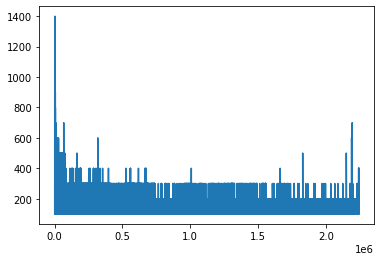

In [167]:
# what's the approx spread
(book.iloc[:, 0] - book.iloc[:, 2]).plot()

<AxesSubplot:ylabel='Frequency'>

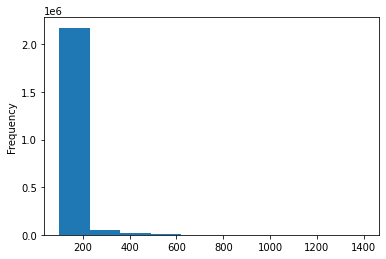

In [169]:
(book.iloc[:, 0] - book.iloc[:, 2]).plot(kind='hist')

In [165]:
# bid side: best - L10
# min tick is 100, hence min 9-level diff is 900
# <= 1000 covers 99.54%

ten_level_diff = (book.iloc[:, 2] - book.iloc[:, -2])
len(ten_level_diff.loc[ten_level_diff <= 1000]) / len(ten_level_diff)

0.9954228384103818

In [180]:
# ask side: L10 - best BID (i.e. including spread)
# min tick is 100, hence min 10-level diff is 1000
# <= 1100 covers 95.85% on ask side
# <= 1400 covers 99.49% on ask side --> use

ten_level_diff = (book.iloc[:, 2] - book.iloc[:, -4])
len(ten_level_diff.loc[ten_level_diff >= -1400]) / len(ten_level_diff)

0.9949025342997566

<AxesSubplot:ylabel='Frequency'>

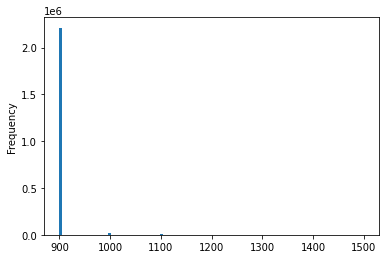

In [147]:
# what's the approx price difference between 10 levels
(book.iloc[10000:, 2] - book.iloc[10000:, -2]).plot(kind='hist', bins=100)

<AxesSubplot:ylabel='Frequency'>

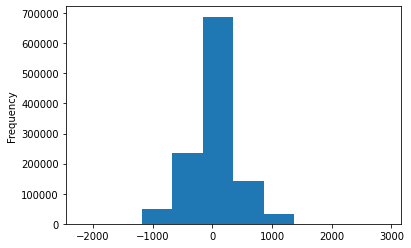

In [129]:
df_.price.plot(kind='hist')

In [104]:
normalize_messages(df_)

,time,event_type,order_id,size,price,direction
1,34200.005721,0,31920154,0,0,0
2,34200.005789,0,31920330,1,1,1
3,34200.006397,0,31921510,1,2,0
5,34200.006966,0,31922478,2,0,0
6,34200.009470,0,31926114,3,3,0
...,...,...,...,...,...,...
1836147,57599.994821,0,727635970,1,219,0
1836148,57599.994850,0,727635974,1,219,0
1836150,57599.994852,0,727635978,1,219,0
1836151,57599.997158,0,727636550,1,219,0


In [ ]:
# size <= 500 rough 99% of data
#      <= 100 85% of orders
# propose encoding: every size until 50, bin 5 until 100, then round to every x100

# price: ultimately, encode relative to mid-price at the time (not available in messages only)
#        for now, just scale absolute price, and bin 10 ticks in distr.

# order id: ignore for now

order types: start with 1, 4, i.e. ignore referential orders (cancel, delete) and hidden

1: Submission of a new limit order

2: Cancellation (partial deletion of a limit order)

3: Deletion (total deletion of a limit order)

4: Execution of a visible limit order

5: Execution of a hidden limit order

6: Indicates a cross trade, e.g. auction trade

7: Trading halt indicator (detailed information below)

In [42]:
window_size = 500
max_deviations = df.price.rolling(window=window_size).apply(lambda seg: (seg - seg.iloc[0]).max())

In [52]:
window_size = 5000
max_deviations_long = df.price.rolling(window=window_size).apply(lambda seg: (seg - seg.iloc[0]).max())

<AxesSubplot:ylabel='Frequency'>

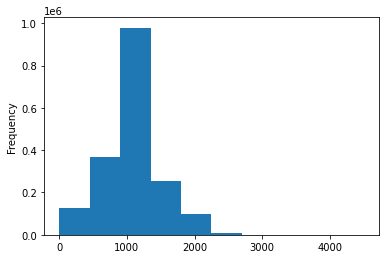

In [48]:
max_deviations.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

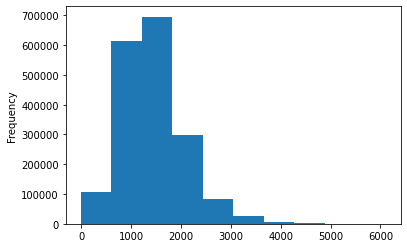

In [53]:
max_deviations_long.plot(kind='hist')

In [39]:
df['price'].describe()

count    1.836155e+06
mean     9.885920e+05
std      4.166003e+03
min      9.769000e+05
25%      9.861000e+05
50%      9.880000e+05
75%      9.905000e+05
max      1.000000e+06
Name: price, dtype: float64

<AxesSubplot:>

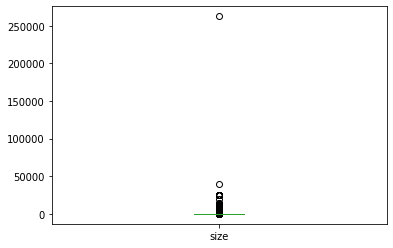

In [19]:
df['size'].plot(kind='box')

In [37]:
len(df.loc[df['size'] <= 100]) / len(df)

0.8534208713316687

<AxesSubplot:>

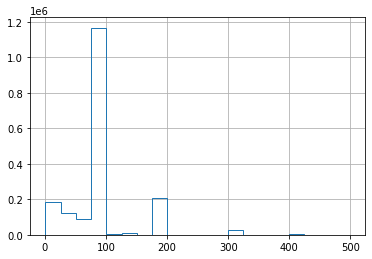

In [31]:
df.loc[df['size'] < 500, 'size'].hist(histtype='step', bins=20)

<AxesSubplot:>

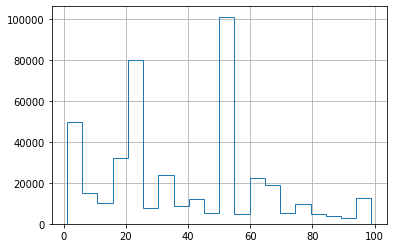

In [38]:
df.loc[df['size'] < 100, 'size'].hist(histtype='step', bins=20)

In [ ]:
args = SimpleNamespace(
    d_model = 128,  # Number of features, i.e. H, dimension of layer inputs/outputs
    n_layers = 6,  # Number of layers in the network
    activation_fn = 'half_glu1', # 
    p_dropout = 0.,  # probability of dropout
    mode = 'pool',  # options: (for classification tasks) pool: mean pooling \\ last: take last element
    prenorm = True,  # True: use prenorm, False: use postnorm
    batchnorm = True,  # True: use batchnorm, False: use layernorm
    bn_momentum = 0.95,  # batchnorm momentum
)

d_output = 2 + 7 + 6 # categorical: 2, 7, contin: 6

In [ ]:
ssm_init_fn = init_S5SSM(
    H=args.d_model,
    P=ssm_size,
    Lambda_re_init=Lambda.real,
    Lambda_im_init=Lambda.imag,
    V=V,
    Vinv=Vinv,
    C_init=args.C_init,
    discretization=args.discretization,
    dt_min=args.dt_min,
    dt_max=args.dt_max,
    conj_sym=args.conj_sym,
    clip_eigs=args.clip_eigs,
    bidirectional=args.bidirectional)

In [ ]:
model_cls = partial(
    LobPredModel,
    ssm=ssm_init_fn,
    d_output=d_output,
    d_model=args.d_model,
    n_layers=args.n_layers,
    padded=False,
    activation=args.activation_fn,
    dropout=args.p_dropout,
    mode=args.mode,
    prenorm=args.prenorm,
    batchnorm=args.batchnorm,
    bn_momentum=args.bn_momentum,
)

In [296]:
from lobster_dataloader import LOBSTER_Dataset

In [297]:
messages = sorted(glob(save_dir + '*message*.csv'))

In [298]:
messages

['/nfs/home/peern/LOBS5/data/GOOG_2023-01-30_34200000_57600000_message_10_proc.csv',
 '/nfs/home/peern/LOBS5/data/GOOG_2023-01-31_34200000_57600000_message_10_proc.csv']

In [328]:
d = LOBSTER_Dataset(message_files=messages, seq_len=500)

In [331]:
d[1000]

Array([[3.4203109e+04, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.4203113e+04, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.4203133e+04, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       ...,
       [3.4205500e+04, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [3.4205500e+04, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00],
       [3.4205500e+04, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00]], dtype=float32)